# Photoplethysmogram(PPG) processing pipeline *Python*

Created on 20201.7.10 by Rain. This notebook this for the physiological data processing of the VR Emotion project

The raw data we will use were obtained from BIOPAC MP160, and first exported in a mat format for segmentation.

Generally, I think the biosinal processing pipeline are basically the same for different kind of data, while the feature extraction can be different. 

In this script, the PPG analysis are mainly conducted by neurokit2, for preprocessing and feature extraction.
Overview:
Step 1: Import raw data
Step 2: Flatten the data & Downsampling
Step 3: Clean the raw data

## Step 1: Import the raw data

In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
data = loadmat('D:/2021_Data_Analysis/2021_VR_Emotion/sub_001_helpless_1.mat')
plt.rcParams['figure.figsize'] = [15, 9]  # Bigger images
plt.rcParams['font.size']= 13

In [2]:
# Let's take a look of our current dataset
print(data);print(type(data));print(data.keys());

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 21 13:57:21 2021', '__version__': '1.0', '__globals__': [], 'ecg_hl1': array([[0.07568359],
       [0.07614136],
       [0.0769043 ],
       ...,
       [0.04180908],
       [0.04226685],
       [0.04364014]]), 'eda_hl1': array([[11.65466267],
       [11.6592403 ],
       [11.65466267],
       ...,
       [11.64703327],
       [11.64703327],
       [11.64398151]]), 'emg_hl1': array([[ 0.00457764],
       [ 0.00030518],
       [-0.01846313],
       ...,
       [-0.00091553],
       [ 0.00045776],
       [ 0.00091553]]), 'emgc_hl1': array([[1.08489990e-04],
       [9.27734375e-05],
       [8.66699219e-05],
       ...,
       [4.30297852e-05],
       [3.71551514e-05],
       [3.39508057e-05]]), 'hr_hl1': array([[83.79888268],
       [83.79888268],
       [83.79888268],
       ...,
       [85.04606662],
       [85.04606662],
       [85.04606662]]), 'ppg_hl1': array([[-0.00091553],
       [-0.00091553],
       [-0.

In [3]:
# Primarily, we can see that within each mat file, the multimodality physiological data were stored into a numpy array individually

## Step 2: Flatten the data array & Downsampling accrodingly(if needed)

In [4]:
ppg=data['ppg_hl1'];ppg.shape 

(216001, 1)

In [5]:
ppg=np.ndarray.flatten(ppg);ppg.shape ## For downsampling and further processing, we should flatten the 2-D array into a 1-D array

(216001,)

In [6]:
#ppg = nk.signal_resample(ppg, method="numpy",sampling_rate=2000, desired_sampling_rate=2000)# Here the neurokit downssampling functionwas used, in the manner of numpy downsampling

In [7]:
ppg.shape

(216001,)

## Step3: Clean the raw PPG data

In [8]:
ppg_cleaned=nk.ppg_clean(ppg,sampling_rate=2000)

## Step4: Locate the peaks of the cleaned PPG signal

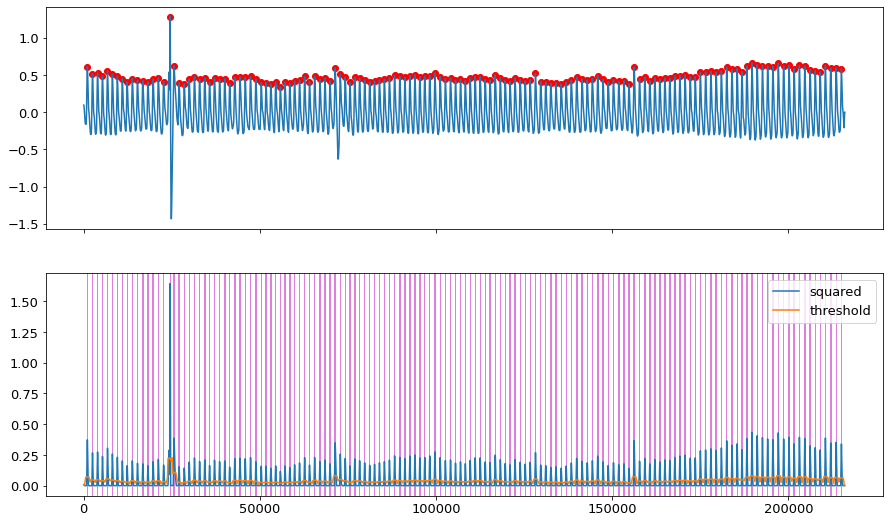

In [9]:
peak_info=nk.ppg_findpeaks(ppg_cleaned,sampling_rate=2000,show=True)

In [36]:
peaks_signal=np.zeros(ppg.shape);peaks_signal.shape

(216001,)

In [19]:
peaks=peak_info['PPG_Peaks'];

1021

In [37]:
peaks_signal[peaks]=1;

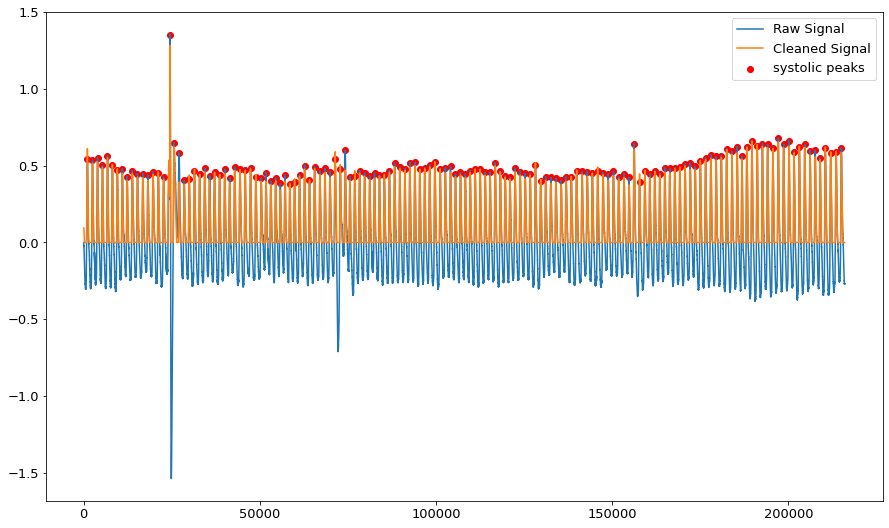

In [11]:
plt.plot(ppg,label='Raw Signal')
plt.plot(ppg_cleaned,label='Cleaned Signal')
plt.scatter(peaks, ppg[peaks], c="r", label="systolic peaks")
plt.legend()

## Step5 : Compute the signal rate

In [12]:
rate=nk.ppg_rate(peaks,sampling_rate=2000,desired_length=len(ppg_cleaned))

In [13]:
rate

array([82.9712684 , 82.9712684 , 82.9712684 , ..., 81.02633356,
       81.02633356, 81.02633356])

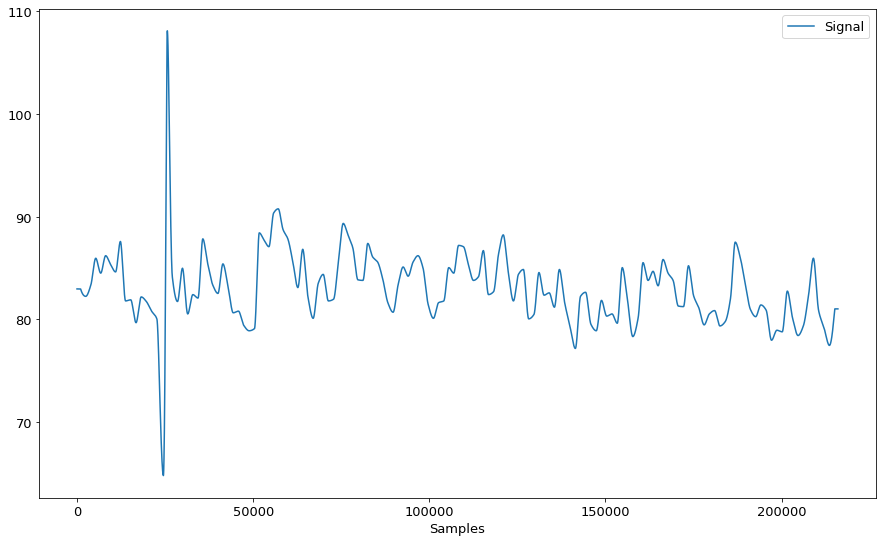

In [14]:
nk.signal_plot(rate)

## Step 6: Aggregate the data and plot

In [38]:
signals=pd.DataFrame({"PPG_Raw":ppg,"PPG_Clean":ppg_cleaned,"PPG_Rate":rate,"PPG_Peaks":peaks_signal})

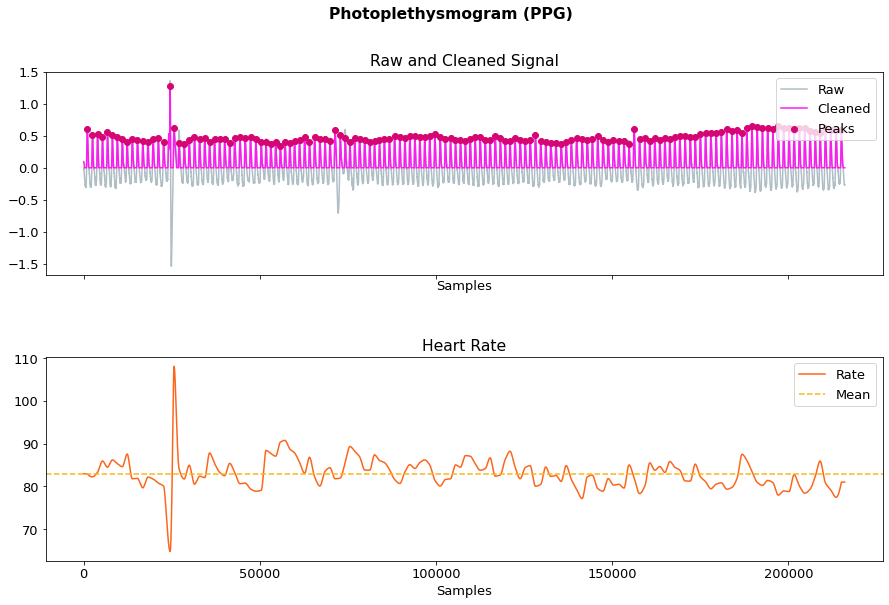

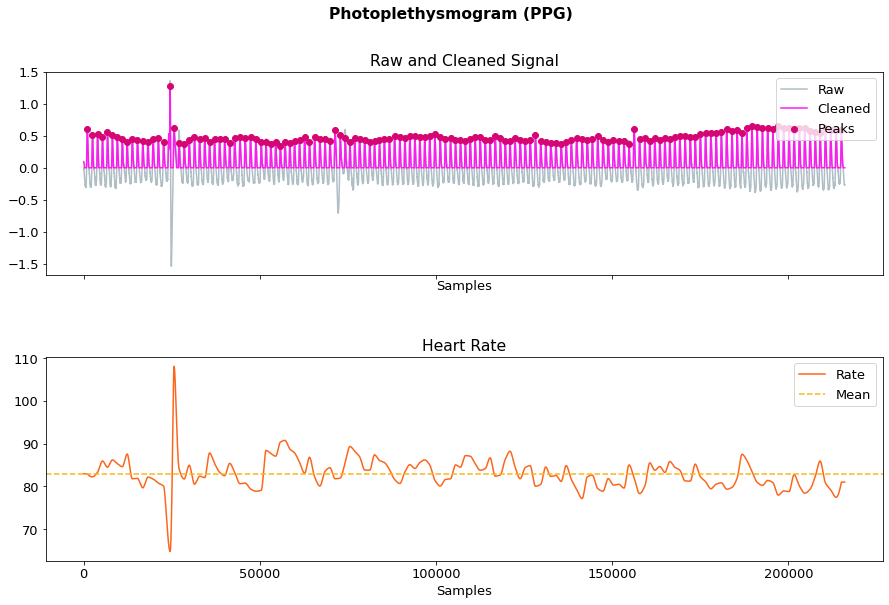

In [39]:
nk.ppg_plot(signals)

## Step 7: Extract the PPG features

In [41]:
ppg_features=nk.ppg_intervalrelated(signals,sampling_rate=2000)

In [42]:
ppg_features

,PPG_Rate_Mean,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,...,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_ApEn,HRV_SampEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_DFA,HRV_CorrDim
0,82.997896,42.519143,723.141892,32.936552,42.664442,0.045546,0.058798,726.25,28.54005,0.039298,...,0.464692,24.16729,22.516926,0.978461,1.79914,0.0,1.505113,1.525721,0.924501,1.017701
